In [1]:
import numpy as np
import pandas
import geopandas
import scipy
import re
from IPython.display import display, HTML
from matplotlib import pyplot as plt
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
datadir = thisdir + 'datasets/'
figdir = thisdir + 'figures/'
#tiger_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/geography/TRACT_SHAPEFILES/'
shapefiledir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'

print('imported')

imported


In [2]:
gdf = geopandas.read_file(datadir+'cra_data_final_for_mac_2015.shp')

with open(datadir+'column_names.csv', 'r') as f:
    y = f.read()
thecolumns = re.split(', ', y)
thecolumns = [x.replace("\\,'", ",") for x in thecolumns]

gdf.columns = thecolumns

gdf = gdf.set_index('census_tract')

print('File has been read!')
#gdf.head(1).T
#thecolumns


File has been read!


# Make some plots

In [3]:
print('reading water features...')
water_gdf = geopandas.read_file(shapefiledir+'water/water.shp', encoding='utf-8')
water_gdf = water_gdf.set_index('OBJECTID')
water_gdf.sort_values('Shape_Area', ascending=False)
water_gdf = water_gdf.to_crs(gdf.crs)
print('Done')
# Lowest decile is 45 jobs, so let's have a cutoff at 50
#gdf['Total number of jobs'].quantile([0.1, 0.5, 0.75])


reading water features...
Done


In [ ]:
gdf.columns.tolist()
gdf = gdf.assign(
    not_hopkins_jobs = gdf['Number of jobs for workers at firms with Firm Size: 0-19 Employees'] + 
        gdf['Number of jobs for workers at firms with Firm Size: 20-49 Employees'] +
        gdf['Number of jobs for workers at firms with Firm Size: 50-249 Employees'] +
        gdf['Number of jobs for workers at firms with Firm Size: 250-499 Employees'] +
        gdf['Number of jobs for workers at firms with Firm Size: 500+ Employees']
)
print('Done')

In [ ]:
scale = 1
show_tract_labels = True
output_figure = False

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60*scale,34*scale))

ax1 = gdf.plot(ax=ax1, color='pink')


ax1 = gdf[gdf['not_hopkins_jobs'] >= 50].plot(ax=ax1, column='amtWorkingLoans_per_job', cmap='viridis', edgecolor='black')
ax1.set_title('Total amount working loans per not-Hopkins job', fontsize=44*scale)
ax1.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax1, color='w')

if (show_tract_labels):
    for ix, thisrow in gdf.iterrows():#[tract_shapes_gdf['population'].notnull()].iterrows():
        annotator = str(ix)
        annotator += '\n' + '${0:,.0f}'.format(thisrow['amtLoansTotal_per_job'])
        annocolor = 'black'
        if (thisrow['not_hopkins_jobs'] >= 50):
            annotator += '\n' + '${0:,.0f}'.format(thisrow['amtLoansTotal_per_job'])
            annocolor = 'black'
        else:
            annocolor = 'grey'
        ax1.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    ha='center', va='center', color=annocolor, backgroundcolor='white', fontsize=11*scale)

ax2 = gdf.plot(ax=ax2, color='pink')
ax2 = gdf[(gdf['pct_white'].notnull())].plot(ax=ax2, column='pct_white', cmap='Greys', edgecolor='yellow')
ax2.set_title('Percent black residents', fontsize=44*scale)
ax2.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax2)
if (show_tract_labels):
    for ix, thisrow in gdf.iterrows():#[tract_shapes_gdf['population'].notnull()].iterrows():
        annotator = str(ix)
        #if ((thisrow['Total number of jobs'] >= 50) & (thisrow['pct_white'] != np.nan)):
        if (thisrow['pct_white'] != np.nan):
            annotator += '\n' + '{0:.1%}'.format(thisrow['pct_white'])
            annocolor = 'black'
        else:
            annocolor = 'grey'
        ax2.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    ha='center', va='center', color=annocolor, backgroundcolor='white', fontsize=11*scale)

ax1.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)

# add colorbar
cax1 = fig.add_axes([0.12, 0.15, 0.36, 0.03])

sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=gdf['amtLoansTotal_per_job'].max()))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal')

cax1.tick_params(labelsize=38*scale)
cbar1.set_label('Amount of CRA loans per job', fontsize=46*scale)


# add colorbar

sm2 = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cax2 = fig.add_axes([0.545, 0.15, 0.36, 0.03])
cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')
cax2.tick_params(labelsize=38*scale)
cbar2.set_label('Percent black residents', fontsize=46*scale)


if (output_figure):
    plt.savefig(figdir+'a_new_loans_per_job_vs_pct_black.svg', format='svg')
    print('Figure saved!')
else:
    plt.show()
print('done')


In [ ]:
gdf['Total number of jobs'].loc[1301.00]#.sort_values(ascending=False)

In [ ]:
gdf = gdf.assign(cra_level = np.nan)

gdf.loc[(gdf['income_group_code'] >= 1) & (gdf['income_group_code'] <= 5), 'cra_level'] = 'low'
gdf.loc[(gdf['income_group_code'] >= 6) & (gdf['income_group_code'] <= 8), 'cra_level'] = 'moderate'
gdf.loc[(gdf['income_group_code'] >= 9) & (gdf['income_group_code'] <= 12), 'cra_level'] = 'middle'
gdf.loc[(gdf['income_group_code'] == 13), 'cra_level'] = 'upper'
gdf.loc[(gdf['income_group_code'] == 14), 'cra_level'] = 'unknown'

data_by_levels_df = pandas.DataFrame(data=gdf.groupby('cra_level')['amtWorkingLoans_per_job'].count())

data_by_levels_df = data_by_levels_df.rename(columns={'amtWorkingLoans_per_job': 'nTracts'})

data_by_levels_df = data_by_levels_df.assign(mean_amtWorkingLoans_per_job = gdf.groupby('cra_level')['amtLoansTotal_per_job'].mean())
data_by_levels_df = data_by_levels_df.assign(sem_amtWorkingLoans_per_job = gdf.groupby('cra_level')['amtLoansTotal_per_job'].sem())

data_by_levels_df = data_by_levels_df.reindex(['low', 'middle', 'moderate', 'upper', 'unknown'])

plt.errorbar(
    data_by_levels_df[data_by_levels_df.index != 'unknown'].index.values, 
    data_by_levels_df[data_by_levels_df.index != 'unknown']['mean_amtWorkingLoans_per_job'], 
    data_by_levels_df[data_by_levels_df.index != 'unknown']['sem_amtWorkingLoans_per_job'],
    linestyle='none', marker='s', markersize=8)
plt.ylim((0,3000))
plt.xlabel('Income level')
plt.ylabel('Mean amount of working loans per job')
plt.title('Mean working loans to census tracts in Baltimore City, 2015')
plt.show()

#annotator = 
#plt.annotate(data_by_levels_df)
htmlString = ''
htmlString += '<table>'
htmlString += '<tr>'
htmlString += '<th>Income level</th>'
htmlString += '<th>Number of census tracts</th>'
htmlString += '<th>Mean CRA loan per job</th>'
htmlString += '<th>Standard error of the mean</th>'
htmlString += '</tr>'

for ix, thisrow in data_by_levels_df.iterrows():
    htmlString += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:.0f}</td><td>${3:.0f}</td></tr>'.format(ix, thisrow['nTracts'], thisrow['mean_amtWorkingLoans_per_job'], thisrow['sem_amtWorkingLoans_per_job'])
htmlString += '<table>'

display(HTML(htmlString))
#data_by_levels_df
#data_by_levels_df


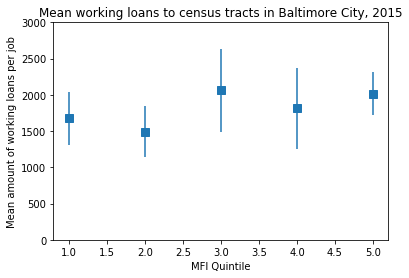

MFI Quintile,Number of census tracts,Mean working loands per job,Standard error of the mean
1,39,$1676,$370
2,39,$1491,$352
3,38,$2061,$572
4,40,$1813,$554
5,39,$2013,$297


In [12]:
mfi_1q_top_cutoff = gdf['mfi'].quantile(0.20)
mfi_2q_top_cutoff = gdf['mfi'].quantile(0.40)
mfi_3q_top_cutoff = gdf['mfi'].quantile(0.60)
mfi_4q_top_cutoff = gdf['mfi'].quantile(0.80)

gdf = gdf.assign(mfi_quintile = np.nan)

gdf.loc[gdf['mfi'] < mfi_1q_top_cutoff, 'mfi_quintile'] = 1
gdf.loc[(gdf['mfi'] >= mfi_1q_top_cutoff) & (gdf['mfi'] < mfi_2q_top_cutoff), 'mfi_quintile'] = 2
gdf.loc[(gdf['mfi'] >= mfi_2q_top_cutoff) & (gdf['mfi'] < mfi_3q_top_cutoff), 'mfi_quintile'] = 3
gdf.loc[(gdf['mfi'] >= mfi_3q_top_cutoff) & (gdf['mfi'] < mfi_4q_top_cutoff), 'mfi_quintile'] = 4
gdf.loc[gdf['mfi'] >= mfi_4q_top_cutoff, 'mfi_quintile'] = 5
gdf.loc[gdf['mfi'].isnull(), 'mfi_quintile'] = -9999

data_by_mfi_quntile_df = pandas.DataFrame(data=gdf.groupby('mfi_quintile')['amtWorkingLoans_per_job'].count())

data_by_mfi_quntile_df = data_by_mfi_quntile_df.rename(columns={'amtWorkingLoans_per_job': 'nTracts'})

data_by_mfi_quntile_df = data_by_mfi_quntile_df.assign(mean_amtWorkingLoans_per_job = gdf.groupby('mfi_quintile')['amtWorkingLoans_per_job'].mean())
data_by_mfi_quntile_df = data_by_mfi_quntile_df.assign(sem_amtWorkingLoans_per_job = gdf.groupby('mfi_quintile')['amtWorkingLoans_per_job'].sem())

plt.errorbar(
    data_by_mfi_quntile_df[data_by_mfi_quntile_df.index > 0].index.values, 
    data_by_mfi_quntile_df[data_by_mfi_quntile_df.index > 0]['mean_amtWorkingLoans_per_job'], 
    data_by_mfi_quntile_df[data_by_mfi_quntile_df.index > 0]['sem_amtWorkingLoans_per_job'],
    linestyle='none', marker='s', markersize=8)
plt.ylim((0,3000))
plt.xlabel('MFI Quintile')
plt.ylabel('Mean amount of working loans per job')
plt.title('Mean working loans to census tracts in Baltimore City, 2015')
plt.show()

#annotator = 
#plt.annotate(data_by_mfi_quntile_df)

htmlString = ''
htmlString += '<table>'
htmlString += '<tr>'
htmlString += '<th>MFI Quintile</th>'
htmlString += '<th>Number of census tracts</th>'
htmlString += '<th>Mean working loands per job</th>'
htmlString += '<th>Standard error of the mean</th>'
htmlString += '</tr>'

for ix, thisrow in data_by_mfi_quntile_df[data_by_mfi_quntile_df.index > 0].iterrows():
    htmlString += '<tr><td>{0:.0f}</td><td>{1:.0f}</td><td>${2:.0f}</td><td>${3:.0f}</td></tr>'.format(ix, thisrow['nTracts'], thisrow['mean_amtWorkingLoans_per_job'], thisrow['sem_amtWorkingLoans_per_job'])
htmlString += '<table>'

display(HTML(htmlString))
#data_by_levels_df
#data_by_levels_df
